# Zillow Data Time Series Analysis

 - Emily Marsh
 - Self Paced
 - Scheduled Project Review Date/Time:
 - Instructor Name: Morgan Jones

# Introduction

In the United States, a common investment oppurtunity for personal and commercial investment is real estate. In 2023 the average the average annual return on investment for residential real estate in the United States is 10.6 percent. Commercial real estate averages a slightly lower ROI of 9.5 percent, while REITs average a slightly higher 11.8 percent. There have been recent historical events that have had an impact on this annual return on investment. The housing crash in 2011 as well as the COVID pandemic of 2020 have had outsized impacts on pricing of housing, however a consistent increase over time has made this an area of consistent profits. Compass Real Estate, an real estate brokerage company that specializes in high-margin, luxury homes in upscale markets, has commissioned this project to expand into a new lower cost housing market in order to appeal to a broader group of clients and quicker cash flow. 

## Business Objective

Compass Real Estate is interested in investing in lower priced housing, under $300,000, for a smaller but more consistent revenue stream to supplement their luxury housing investments. This will also give the company the chance to expand their client base to more middle class home buyers. However, before investing capitol in this new venture, Compass would like to do analysis into determining the best five zipcodes that provides the biggest chance of profit. Using the dataset, this analysis will provide insight into the five best zip codes for investment as well as the projected profits over the next five years in each zip code. These predication will be made using Time Series modeling. 

## Dataset

The dataset used for this project is a subset of a larger dataset from Zillow, and consists of **14,732 rows** and **272 columns**. The format of the dataset includes features about **RegionID, Region Name (Zipcode), City, State, Metro, County Name, Size Rank**, and the **average price of houses in the zipcode starting in April of 1994 and ending with April of 2018**. Each **RegionName/Zipcode** is a unique value, while **Metro and County Name** are not. It is also important to note that the dataset is in a **wide format** versus a **long format**. Therefore in order to pass this data into an ARIMA model, the dataset will need to be reshaped to a **long format**. 

## Import Libraries

In [85]:
#Importing necessary Packages

import warnings
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
from collections import Counter
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.pylab import rcParams
%matplotlib inline
import geopandas as gpd
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon
from neuralprophet import NeuralProphet
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')

## Initial Data Exploration

In [2]:
#using CSV reader to read dataframe into pandas

df = pd.read_csv('zillow_data.csv')

In [3]:
#initial overview of datasets columns and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [4]:
#exploring the total amount of columns and rows in dataset

df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


In [5]:
#observing values and format of the dataframe
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


## Data Understanding

Within this dataset, 4 of the features are string values, 49 are integers, and 219 are floats. As was mentioned earlier, this dataset is in a wide format instead of a long format. Long format will be necessary for passing the dataset into an ARIMA model. Additional investigation will be necessary to determine if there are any null values in the dataset that could interfere with accurate results. 

## Check for Null Values

In [6]:
# checking for null values and returning it as a pandas series
empty=df.isna().sum()
empty.head(20)

RegionID         0
RegionName       0
City             0
State            0
Metro         1043
CountyName       0
SizeRank         0
1996-04       1039
1996-05       1039
1996-06       1039
1996-07       1039
1996-08       1039
1996-09       1039
1996-10       1039
1996-11       1039
1996-12       1039
1997-01       1039
1997-02       1039
1997-03       1039
1997-04       1039
dtype: int64

After additional investigation, the dataset appears to contain null values in metro and in some of the prices. Since the dataset that will be modeled will be a subset of this dataset, the prescence of null values will be checked again. 

# Data Preparation

The profit of each zip code will be determined by subtracting the original price of the average property in April of 1996 from the average property value in April of 2018. Due to the client's budget, the available houses will be limited by price, only properties with a value of under $300,000 as of April 2018. Since Compass is a national company, geography is not a limiting factor for investment consideration therefore no geographical constraints will be used to limit the available zipcodes. 

## Filtering for Properties Under Client Budget

Since Compass Real Estate is interested in expanding into more middle class housing, the analysis will focus on properties that are under the price of $300,000 as of April 2018.

In [7]:
#creating new dataframe with only properties that are under $300,000 as of 2018-04
client_budget = df[df['2018-04']<=300000]

In [8]:
#Examining new dataframe size with budget restrictions
client_budget

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
8,91940,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,95800.0,...,166800,167400,168400,169600,170900,172300,173300,174200,175400,176200
11,71831,32162,The Villages,FL,The Villages,Sumter,12,101000.0,100700.0,100400.0,...,249900,250400,249900,248700,247500,247100,246800,247500,249800,251800
14,74101,37013,Nashville,TN,Nashville,Davidson,15,112400.0,112700.0,113000.0,...,193000,194900,196600,198800,201300,203800,205900,207600,210000,211900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14715,62556,12429,Esopus,NY,Kingston,Ulster,14716,78300.0,78300.0,78200.0,...,164200,166600,170000,171000,170700,171300,172400,173600,175800,177500
14717,62697,12720,Bethel,NY,NaN,Sullivan,14718,62500.0,62600.0,62700.0,...,122200,122700,122300,122000,122200,122800,123200,123200,120700,117700
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800


Even with the budget limit of $3000,000, Compass Real Estate has many zipcodes to potentially choose from. In order to determine which zipcodes have the greates ROI, a new column will be created to show the total increase in value from April of 1996 to April of 2018.

## Creating Total Price Increase Column to Dataframe

Since the client, Compass Real Estate, is interested in maximizing profits, a new column showing the total increase in price from April of 1996 to April of 2018 will be added to the dataset. As a result, a house that has gained the most value over this time period will be the most desirable for the clients. 

In [9]:
#Creating a new column with April 2018 price minus the price in April of 1996 to show overall value increase over 
#the time period
client_budget.loc[:,'Total Price Increase'] = (
    client_budget['2018-04'] - client_budget['1996-04']
            )

In [10]:
client_budget

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Total Price Increase
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119400,120000,120300,120300,120300,120300,120500,121000,121500,44200.0
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,158700,160200,161900,162800,162800,162800,162900,163500,164300,69300.0
8,91940,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,95800.0,...,167400,168400,169600,170900,172300,173300,174200,175400,176200,80800.0
11,71831,32162,The Villages,FL,The Villages,Sumter,12,101000.0,100700.0,100400.0,...,250400,249900,248700,247500,247100,246800,247500,249800,251800,150800.0
14,74101,37013,Nashville,TN,Nashville,Davidson,15,112400.0,112700.0,113000.0,...,194900,196600,198800,201300,203800,205900,207600,210000,211900,99500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14715,62556,12429,Esopus,NY,Kingston,Ulster,14716,78300.0,78300.0,78200.0,...,166600,170000,171000,170700,171300,172400,173600,175800,177500,99200.0
14717,62697,12720,Bethel,NY,NaN,Sullivan,14718,62500.0,62600.0,62700.0,...,122700,122300,122000,122200,122800,123200,123200,120700,117700,55200.0
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,217700,218600,218500,218100,216400,213100,209800,209200,209300,114700.0
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,208400,212200,215200,214300,213100,213700,218300,222700,225800,133100.0


From the limited view of the available 10,632 rows, a range of profits over time are already evident. It will be necessary to order the data by these values to determine which zip codes have the greatest value increase.  

## Ordering By Total Price Increase and Creating a Top 25 Zip Code Dataset

Since the client is limited by resources to only focus on five zipcodes, the top 25 Zip Codes will be modeled to give options for modeling and selecting the top five zip codes that maximize profit. 

In [11]:
#ordering the dataframe from highest value of Total Price Increase to find the top 25 zipcodes 
top_25_zips = client_budget.sort_values(by=['Total Price Increase'], ascending=False).head(25)

In [12]:
#examine new dataframe of top 25 zipcodes according to total price increase
top_25_zips

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Total Price Increase
13830,66102,19951,Harbeson,DE,Salisbury,Sussex,13831,34500.0,34900.0,35200.0,...,258600,258100,260300,265400,269300,272100,275300,277000,276900,242400.0
14217,93399,80449,Hartsel,CO,Denver,Park,14218,30000.0,30400.0,30900.0,...,244600,248000,251300,252900,254700,256600,259200,263400,267700,237700.0
3615,65792,19125,Philadelphia,PA,Philadelphia,Philadelphia,3616,32600.0,32700.0,32800.0,...,249000,251600,253900,255700,257100,258000,258500,260500,262300,229700.0
11353,95177,86334,Paulden,AZ,Prescott,Yavapai,11354,41100.0,41400.0,41700.0,...,229800,232000,237000,242800,249200,253900,257800,263900,269900,228800.0
2656,73011,34120,Naples,FL,Naples,Collier,2657,68600.0,67900.0,67200.0,...,289800,291800,293800,294000,293700,294600,294700,295100,296200,227600.0
8350,92632,78721,Austin,TX,Austin,Travis,8351,69200.0,68800.0,68400.0,...,281200,281500,284000,288500,293000,296300,297800,297200,296100,226900.0
3153,99192,97321,Albany,OR,Albany,Linn,3154,71600.0,71900.0,72200.0,...,286800,288600,289500,289700,290700,292100,293200,295200,297700,226100.0
13470,82893,56511,Audubon,MN,NaN,Becker,13471,59200.0,59300.0,59500.0,...,281000,280500,279100,277700,278100,279800,280100,281400,284300,225100.0
8743,99229,97370,Philomath,OR,Corvallis,Benton,8744,69300.0,69700.0,70000.0,...,278300,281300,284400,287100,290100,292900,293000,291800,291500,222200.0
10598,64752,16827,Boalsburg,PA,State College,Centre,10599,67500.0,67700.0,67900.0,...,274400,277000,278200,279000,279800,279700,280800,284300,287800,220300.0


In [13]:
empty_25=top_25_zips.isna().sum()
empty_25.head(40)

RegionID      0
RegionName    0
City          0
State         0
Metro         2
CountyName    0
SizeRank      0
1996-04       0
1996-05       0
1996-06       0
1996-07       0
1996-08       0
1996-09       0
1996-10       0
1996-11       0
1996-12       0
1997-01       0
1997-02       0
1997-03       0
1997-04       0
1997-05       0
1997-06       0
1997-07       0
1997-08       0
1997-09       0
1997-10       0
1997-11       0
1997-12       0
1998-01       0
1998-02       0
1998-03       0
1998-04       0
1998-05       0
1998-06       0
1998-07       0
1998-08       0
1998-09       0
1998-10       0
1998-11       0
1998-12       0
dtype: int64

After checking, the Top 25 Zip Codes dataset only contains two null values in the Metro column. This feature column is unimportant to the modeling process as this feature will be dropped in favor of using RegionName/Zipcode. 

## Visualizing the Geographic Spread of the Top 25 Zip Codes

Despite the client, Compass Real Estate, not being limited to geographic locations, it is valuable to see any geographic trends among the top 25 zipcodes for potential maximizing of resources. A dataset with latitute and longitude values for each Zipcode will be created in order to create a useful visual. 

In [14]:
#extracting the top 25 Zipcodes from the dataset
list(top_25_zips['RegionName'])

[19951,
 80449,
 19125,
 86334,
 34120,
 78721,
 97321,
 56511,
 97370,
 16827,
 16801,
 32233,
 86323,
 55409,
 56442,
 80456,
 33947,
 63108,
 56443,
 70734,
 37216,
 57110,
 19968,
 30316,
 33602]

In [15]:
#creating a list of values for the longitude and latitude of each Zipcode
coord = [(19951, 38.6898, -75.24000), (80449, 38.95689,-105.87044), (19125, 39.97641,-75.12217), (86334, 34.94867,-112.54443), 
        (34120, 26.32277,-81.55923),(78721, 30.26619,-97.68476), (97321, 44.63339,-123.13956), (56511, 46.84768,-96.01409), (97370, 44.59613,-123.45873), 
         (16827, 40.77297,-77.76024), (16801, 40.78681,-77.84438), (32233, 30.36143,-81.42642), (86323, 34.83896,-112.39677), (55409, 44.92652,-93.29081), (56442, 46.68866,-94.09915),
        (80456, 39.35346,-105.77032), (33947, 26.88093,-82.26993), (63108, 38.64461,-90.25198), (56443, 46.19521,-94.55463), (70734, 30.20703,-91.00902),
        (37216, 36.21681,-86.72443), (57110, 43.54969,-96.63113), (19968, 38.76454,-75.29784), (30316, 33.71759,-84.33225), (33602, 27.94946,-82.46118)]

In [16]:
#creating a dataframe with the longitude, latitude, and RegionName values
zip_long_lat = pd.DataFrame(coord, columns=['RegionName', 'Latitude', 'Longitude'])

In [17]:
#examining dataframe
zip_long_lat

,RegionName,Latitude,Longitude
0,19951,38.68980,-75.24000
1,80449,38.95689,-105.87044
2,19125,39.97641,-75.12217
3,86334,34.94867,-112.54443
4,34120,26.32277,-81.55923
5,78721,30.26619,-97.68476
6,97321,44.63339,-123.13956
7,56511,46.84768,-96.01409
8,97370,44.59613,-123.45873
9,16827,40.77297,-77.76024


In [18]:
#merging the latitude and longitude dataframe with the Top 25 Zipcode Dataframe
top_25_full_df = pd.merge(top_25_zips, zip_long_lat, on=["RegionName"])

In [19]:
#examining new full dataset
top_25_full_df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Total Price Increase,Latitude,Longitude
0,66102,19951,Harbeson,DE,Salisbury,Sussex,13831,34500.0,34900.0,35200.0,...,260300,265400,269300,272100,275300,277000,276900,242400.0,38.68980,-75.24000
1,93399,80449,Hartsel,CO,Denver,Park,14218,30000.0,30400.0,30900.0,...,251300,252900,254700,256600,259200,263400,267700,237700.0,38.95689,-105.87044
2,65792,19125,Philadelphia,PA,Philadelphia,Philadelphia,3616,32600.0,32700.0,32800.0,...,253900,255700,257100,258000,258500,260500,262300,229700.0,39.97641,-75.12217
3,95177,86334,Paulden,AZ,Prescott,Yavapai,11354,41100.0,41400.0,41700.0,...,237000,242800,249200,253900,257800,263900,269900,228800.0,34.94867,-112.54443
4,73011,34120,Naples,FL,Naples,Collier,2657,68600.0,67900.0,67200.0,...,293800,294000,293700,294600,294700,295100,296200,227600.0,26.32277,-81.55923
5,92632,78721,Austin,TX,Austin,Travis,8351,69200.0,68800.0,68400.0,...,284000,288500,293000,296300,297800,297200,296100,226900.0,30.26619,-97.68476
6,99192,97321,Albany,OR,Albany,Linn,3154,71600.0,71900.0,72200.0,...,289500,289700,290700,292100,293200,295200,297700,226100.0,44.63339,-123.13956
7,82893,56511,Audubon,MN,NaN,Becker,13471,59200.0,59300.0,59500.0,...,279100,277700,278100,279800,280100,281400,284300,225100.0,46.84768,-96.01409
8,99229,97370,Philomath,OR,Corvallis,Benton,8744,69300.0,69700.0,70000.0,...,284400,287100,290100,292900,293000,291800,291500,222200.0,44.59613,-123.45873
9,64752,16827,Boalsburg,PA,State College,Centre,10599,67500.0,67700.0,67900.0,...,278200,279000,279800,279700,280800,284300,287800,220300.0,40.77297,-77.76024


In [20]:
#Importinga shp of the USA map for visualization
mapdf = top_25_full_df.copy()

usa_map = gpd.read_file('tl_2017_us_state/tl_2017_us_state.shp')
usa_map = usa_map.to_crs("EPSG:4326")

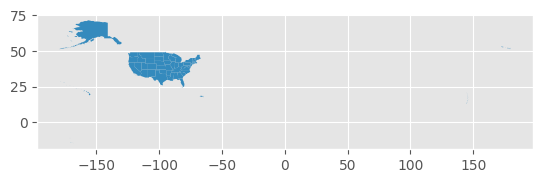

In [21]:
#examining SHP file
usa_map.plot();

In [22]:
#Removing Non Continental States from Visualization
non_continental = ['HI','VI','MP','GU','AK','AS','PR']
us49 = usa_map
for n in non_continental:
    us49 = us49[us49.STUSPS != n]

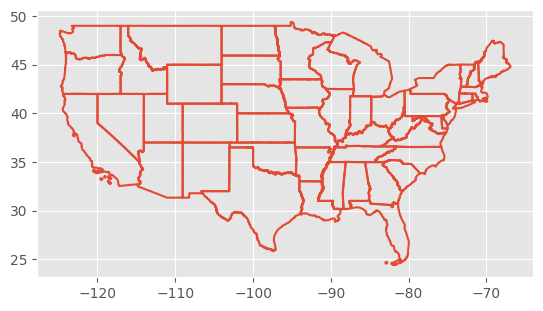

In [23]:
#examining new chart
us49.boundary.plot()
plt.show()

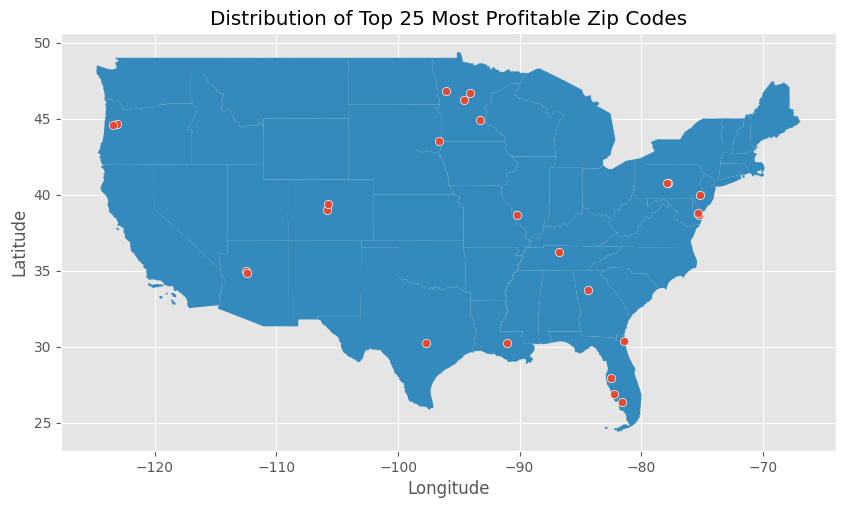

In [24]:
#Plotting the Top 25 Zip Codes on USA Chart
crs = {'init':'EPSG:4326'} #define CRS
geometry = [Point(xy) for xy in zip(mapdf['Longitude'], top_25_full_df['Latitude'])] #create Points
geo_df = gpd.GeoDataFrame(mapdf, 
                          crs = crs, 
                          geometry = geometry) #define the geometry df

#plot the data
fig, ax = plt.subplots(figsize = (10,10))
us49.to_crs(epsg=4326).plot(ax=ax)
sns.scatterplot(x="Longitude", y="Latitude",data=mapdf, ax=ax)
ax.set_title('Distribution of Top 25 Most Profitable Zip Codes');

As can be seen on the chart, there are some interesting geographic concentrations that could be of interest to the clients if there was a desire to consolidate resources geographically. The analysis of this project, however, will move forward with recommendations based solely on ROI considerations with no geographic consideration. 

## Visualizing the Price history of filtered Zip Codes since 1996

An important aspect of times series data anlysis is making sure that the modeling is not overall affected by seasonality or trends within the data. To get a better sense of the shape of the price history, a visualization of the price history since 1996 will be utilized.

In [25]:
#creating a function to convert the dataset from wide format to long format
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby(['time']).aggregate({'value':'mean'})

In [26]:
#drop extra columns not needed for modeling
top_25_modeling_df = top_25_full_df.drop(['Total Price Increase', 'Latitude', 'Longitude'], axis=1)

In [27]:
#examine new dataset with dropped columns for modeling
top_25_modeling_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,66102,19951,Harbeson,DE,Salisbury,Sussex,13831,34500.0,34900.0,35200.0,...,260000,258600,258100,260300,265400,269300,272100,275300,277000,276900
1,93399,80449,Hartsel,CO,Denver,Park,14218,30000.0,30400.0,30900.0,...,243200,244600,248000,251300,252900,254700,256600,259200,263400,267700
2,65792,19125,Philadelphia,PA,Philadelphia,Philadelphia,3616,32600.0,32700.0,32800.0,...,247500,249000,251600,253900,255700,257100,258000,258500,260500,262300
3,95177,86334,Paulden,AZ,Prescott,Yavapai,11354,41100.0,41400.0,41700.0,...,230300,229800,232000,237000,242800,249200,253900,257800,263900,269900
4,73011,34120,Naples,FL,Naples,Collier,2657,68600.0,67900.0,67200.0,...,288300,289800,291800,293800,294000,293700,294600,294700,295100,296200


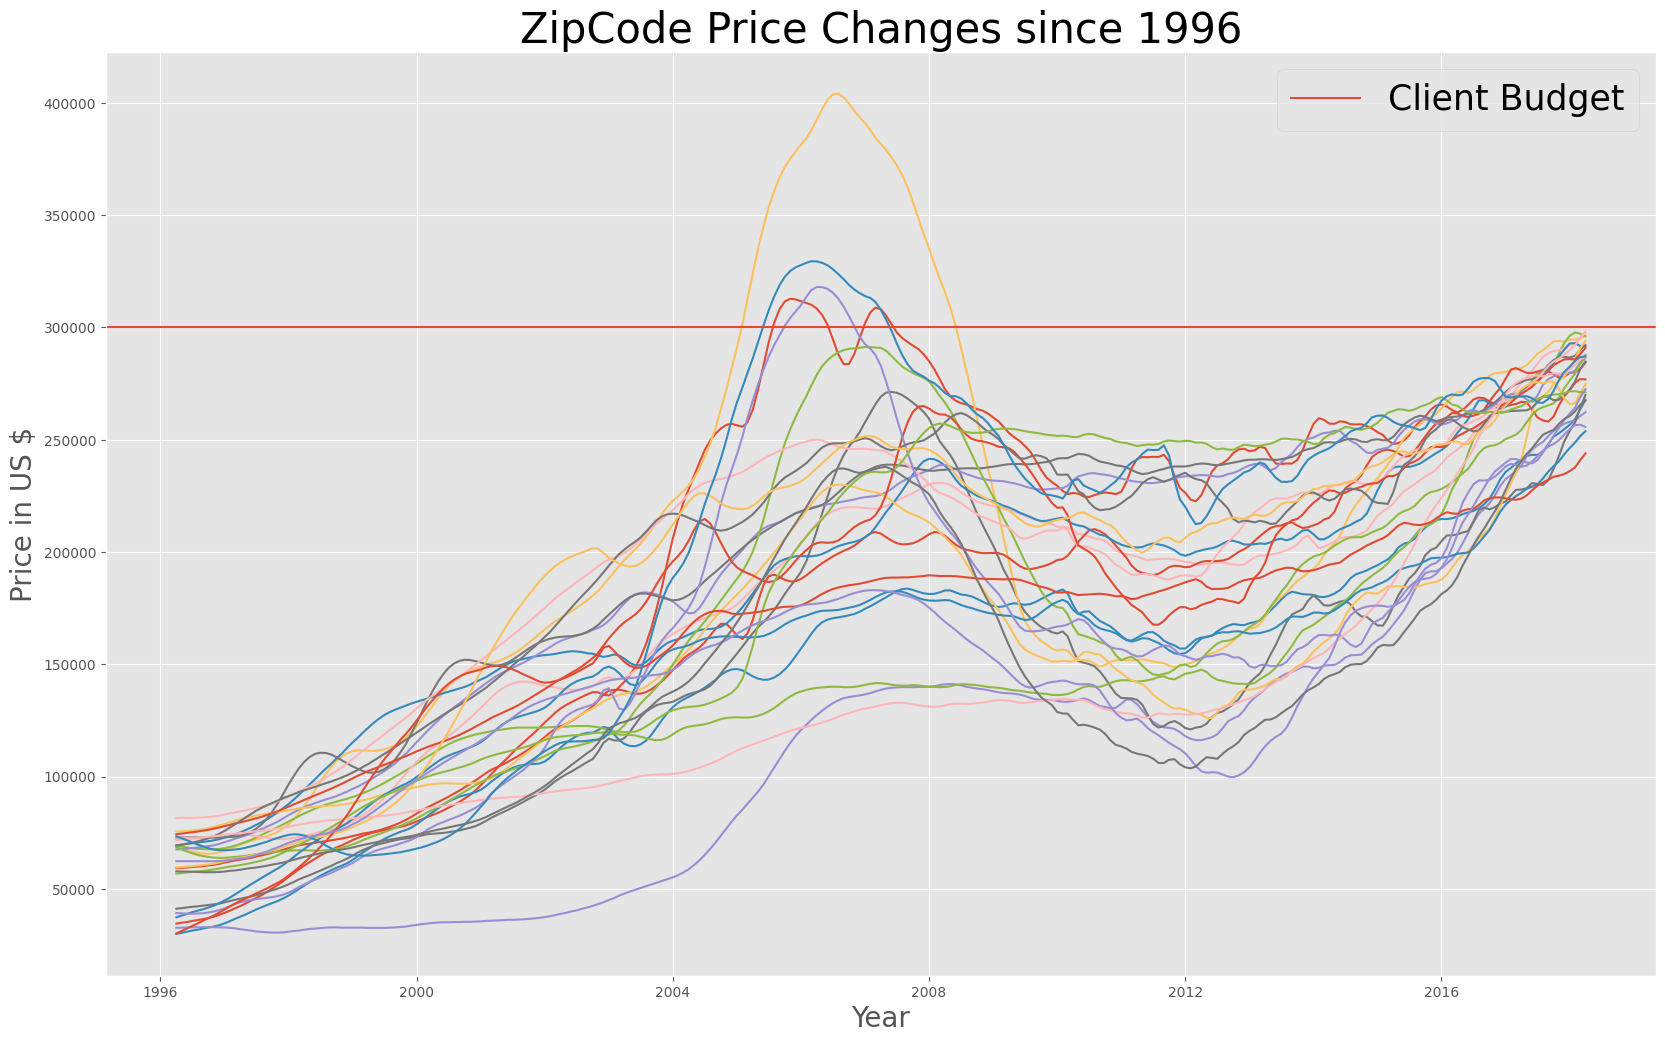

In [28]:
#creating plot of prices changes by zipcode since 1996
zip_dict = {}

for zipcode in top_25_modeling_df['RegionName']:
    zip_dict[zipcode] = melt_data(top_25_modeling_df[top_25_modeling_df['RegionName']==zipcode])

fig,ax = plt.subplots(figsize=(20,12))

for zipcode in zip_dict:
    ax.plot(zip_dict[zipcode],)

ax.axhline(y=300000,label = 'Client Budget')   

ax.set_title('ZipCode Price Changes since 1996',fontsize=30)
ax.set_ylabel('Price in US $',fontsize=20)
ax.set_xlabel('Year',fontsize=20)
ax.legend(prop={'size': 25});

As can be seen in the visualization, there was an increase of prices and then a steep decline around 2008. This corresponds with the 2008 financial housing crisis and recession. Since then, it appears that prices have been steadily on the rise since 2011 but have yet to reach their pre-recession peaks. There area also some interesting outliers in the data that grew and declined rapidly around 2008.

## Visualizing the The Zip Codes' Average Price Growth

Creating a visualization of which zipcodes have been growing the fastest since then will be a helpful tool to determine which zipcodes should be used for modeling. 

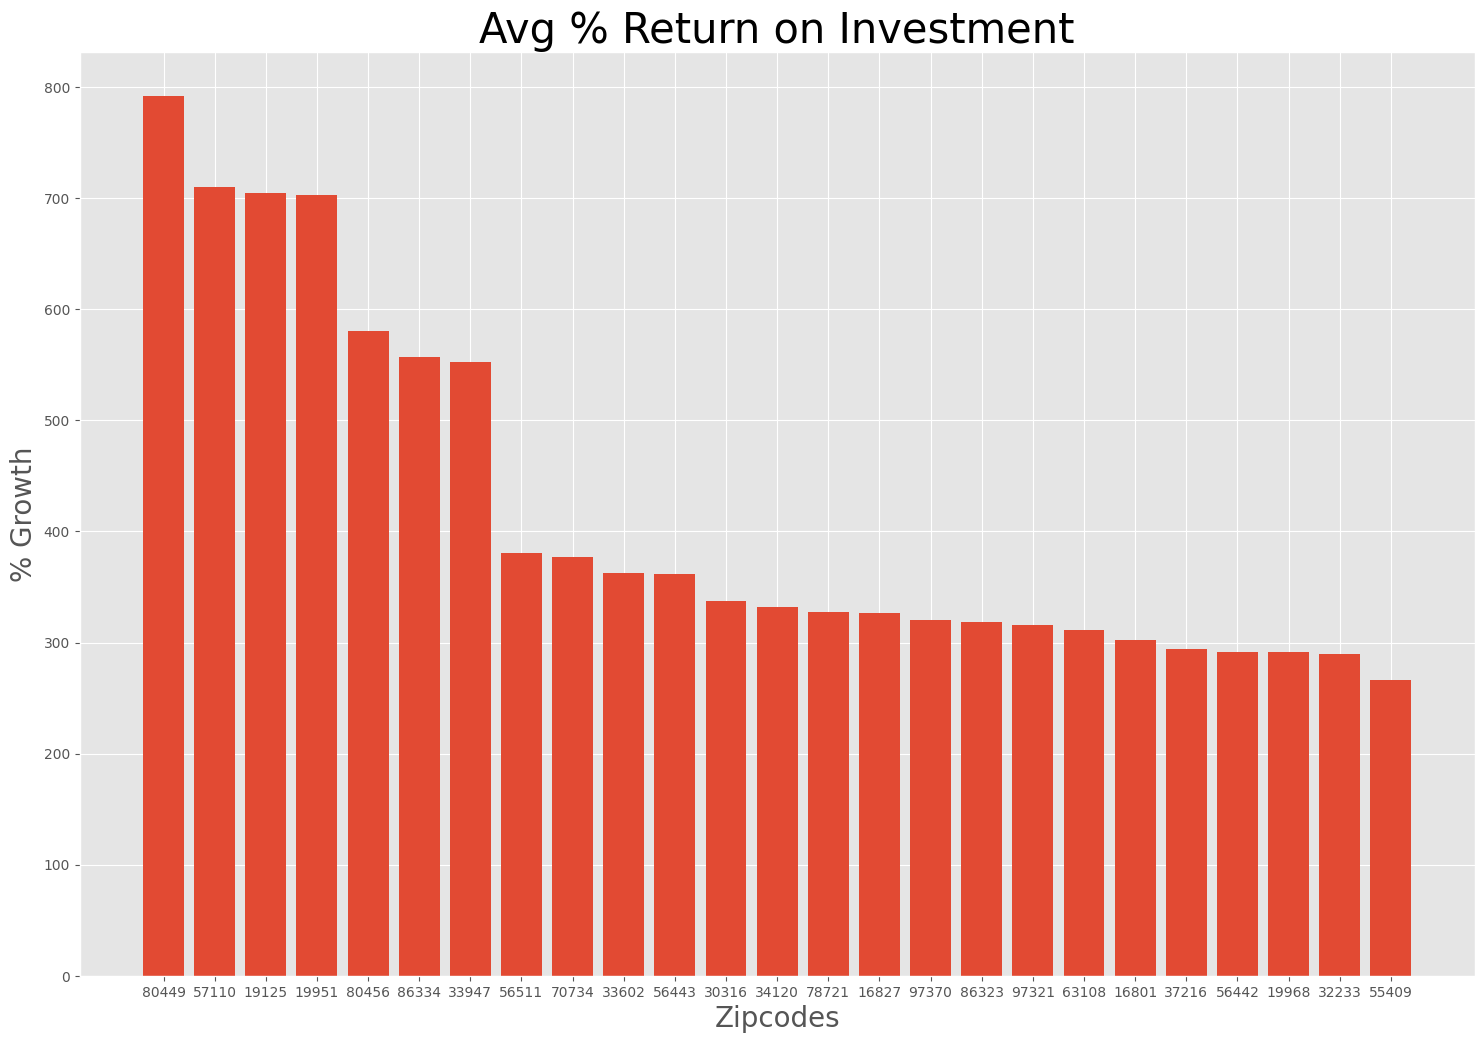

In [29]:
#creating a bar graph visual that shows the average return on investment for each of the top 25 zipcodes
warnings.filterwarnings('ignore')

#creating column with ROI since 2011
top_25_2011_roi = top_25_modeling_df
top_25_2011_roi['roi_since1996'] = (
    (top_25_2011_roi['2018-04']-top_25_2011_roi['1996-04'])/(top_25_2011_roi['1996-04'])*100)
top_25_2011_roi = top_25_2011_roi.sort_values('roi_since1996',ascending=False)

warnings.filterwarnings('ignore')

#plotting column roi_since11 for each zipcode
fig,ax=plt.subplots(figsize=(18,12))

x_labels = [str(a) for a in top_25_2011_roi['RegionName']]
x = list(range(1,26))
y = [a for a in top_25_2011_roi['roi_since1996']]

ax.bar(x,y)

ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_ylabel('% Growth',fontsize='20')
ax.set_xlabel('Zipcodes',fontsize='20')
ax.set_title('Avg % Return on Investment',fontsize='30');

We can see from above that the highest growing zip code since 1996 is 80449. It is also of interest to note that the top six zipcodes seem concentrated around the same geographic area. Areas of growth not being limited to one zipcode is an interesting oppurtunity for clients to acheive the highest ROI while also concentrating resources. 

# Selecting a ZipCode for the Initial Time Series Model

In order to build a time series model that predicts the future ROI of each of the top 25 zipcodes within the client's budget, an initial time series model must be built on one of the zipcodes in the dataset. Since zipcode 80449 is the fastest growing it will be used to construct the initial time series model. Therefore, the first time series model will predict what the future value of 80449 will be. A similar workflow can then be utilized on the other zipcodes within the dataset to identify which five zipcodes have the highest predicted ROI. 

In [30]:
#dataframe containing zipcode 80449
zip80449 = df[df['RegionName']==80449]

In [31]:
#melting zipcode 80449 from wide to long format
series80449 = melt_data(zip80449)

In [32]:
#examining 80449 long format dataset
series80449

,value
time,
1996-04-01,30000.0
1996-05-01,30400.0
1996-06-01,30900.0
1996-07-01,31400.0
1996-08-01,31800.0
...,...
2017-12-01,254700.0
2018-01-01,256600.0
2018-02-01,259200.0


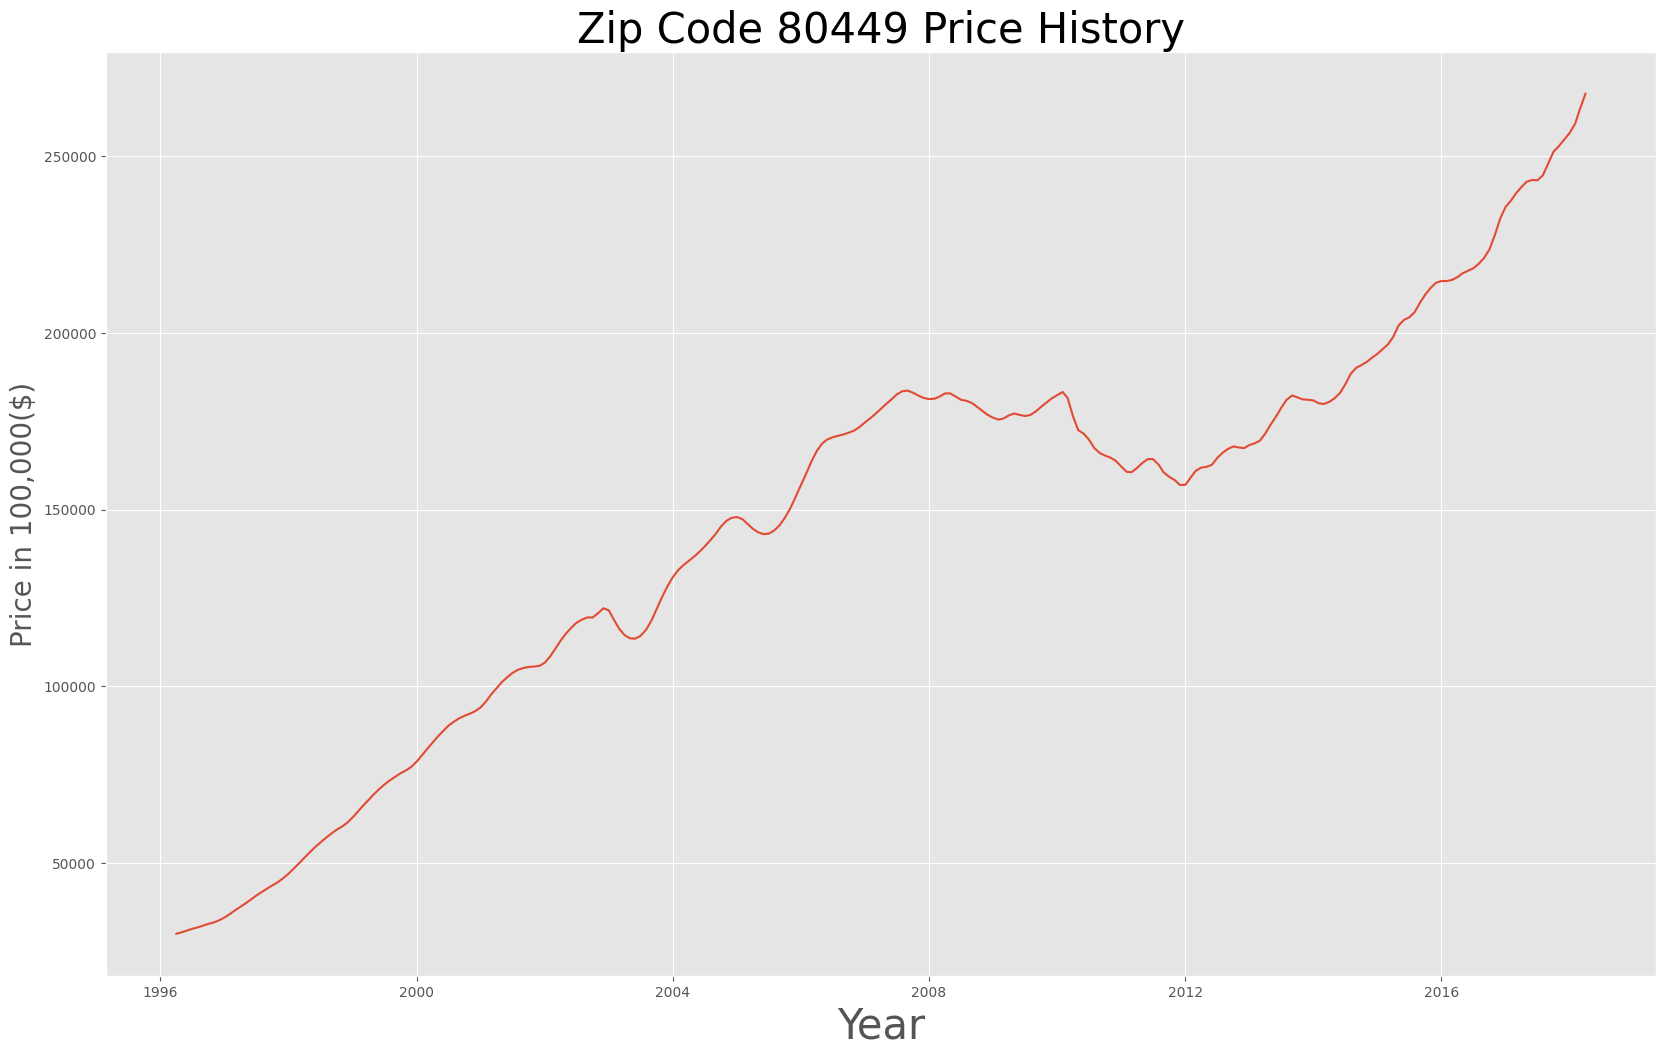

In [33]:
#Visualizing the Time Series Data for zipcode- 80449

fig, ax = plt.subplots(figsize=(20,12))
ax.plot(series80449)

ax.set_xlabel('Year', fontsize=30)
ax.set_ylabel('Price in 100,000($)',fontsize=20)
ax.set_title('Zip Code 80449 Price History',fontsize=30);

After having examined the price history of all the zipcodes in the top 25 dataset, individually the zipcode of 33602 follows similar patterns. There is a sharp increase in price followed by a small descent around the year 2008, and then continuing a steady increase starting in 2012. As a result, it seems reasonable to expect that a time series model of this individual zipcode will also be successful with the remaining zipcodes in the dataset. 

# Seasonal Decomposition

In [ ]:
# I will be using logged and difference data in the models but would like to look at how decomposition works for EDA

# Apply seasonal_decompose()
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(np.log(Philly_melted))

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(Philly_melted, label='Original')#np.log(ts)
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.savefig('Images/decomposition.png')
plt.tight_layout()

# Splitting Our Data into Train and Test

In order to evaluate the accuracy of the predictions generated by the models, a train test split will be utilized. The train-test split for a time series is a little different from what we are used to. Because chronological order matters, we cannot randomly sample points in our data. Instead, we cut off a portion of our data at the end, and reserve it as our test set.

In [34]:
# find the index which allows us to split off 20% of the data
cutoff = round(series80449.shape[0]*0.8)
cutoff

212

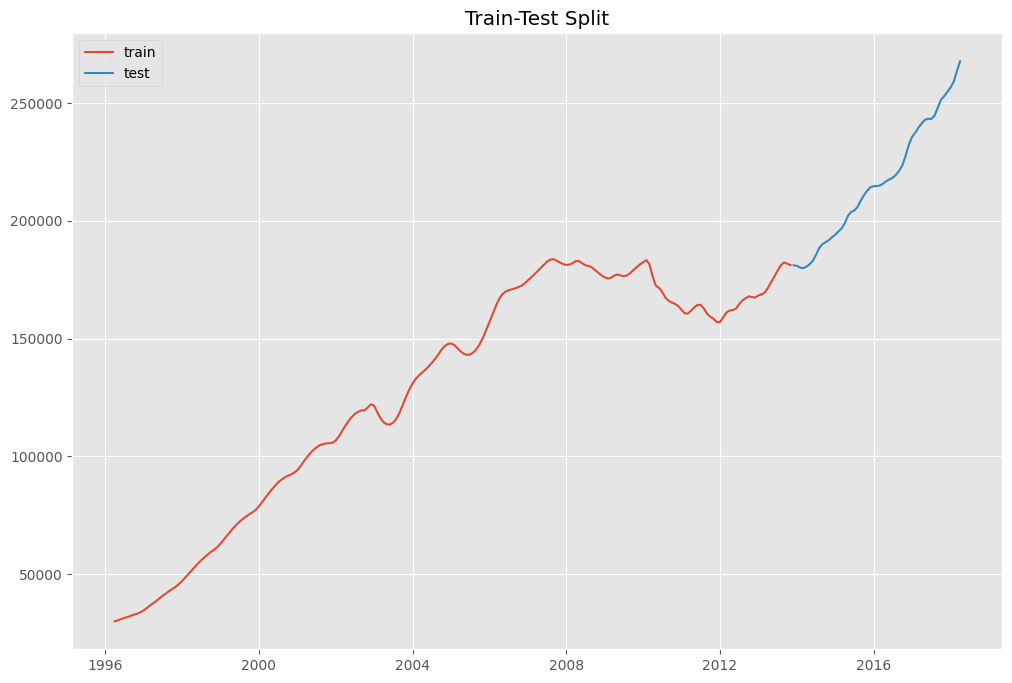

In [35]:
# Define train and test sets according to the index found above
train = series80449[:cutoff]

test = series80449[cutoff:]

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

In [36]:
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train):
    print(train_ind, val_ind)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36] [37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60
 61 62 63 64 65 66 67 68 69 70 71]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71] [ 72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 1

## Establishing A Baseline Model

In [37]:
# we can perform this with the shift operator
# The prediction for the next day is the original series shifted to the future by one day.
naive = train.shift(1)
naive

,value
time,
1996-04-01,NaN
1996-05-01,30000.0
1996-06-01,30400.0
1996-07-01,30900.0
1996-08-01,31400.0
...,...
2013-07-01,176300.0
2013-08-01,178800.0
2013-09-01,181100.0


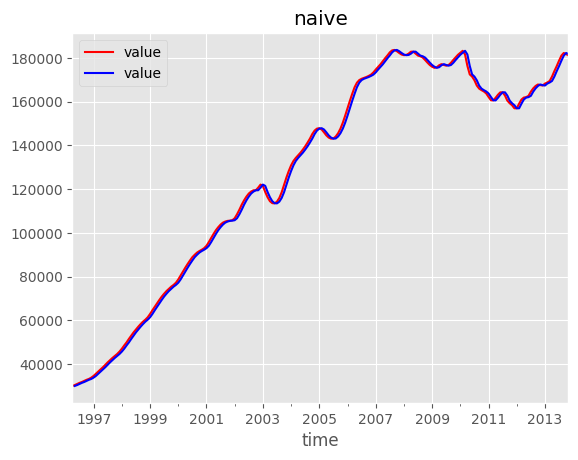

In [38]:
fig, ax = plt.subplots()

train[0:212].plot(ax=ax, c='r', label='original')
naive[0:212].plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

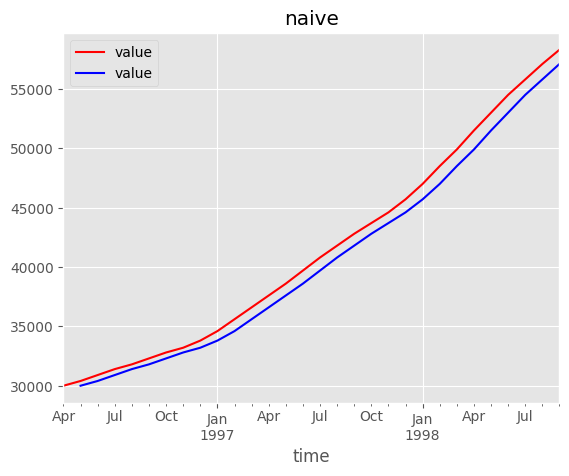

In [39]:
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
naive[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

For a baseline to compare our later models, lets calculate our RMSE for the naive model.

In [40]:
base_rmse = np.sqrt(mean_squared_error(train[1:], naive.dropna()))
print(base_rmse)

1473.5262538730283


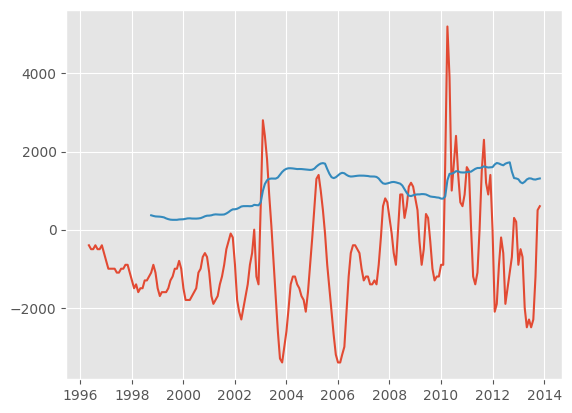

In [41]:
fig, ax = plt.subplots()
residuals = naive[1:] -train[1:]
ax.plot(residuals.index, residuals['value'])
ax.plot(residuals.index, residuals['value'].rolling(30).std());

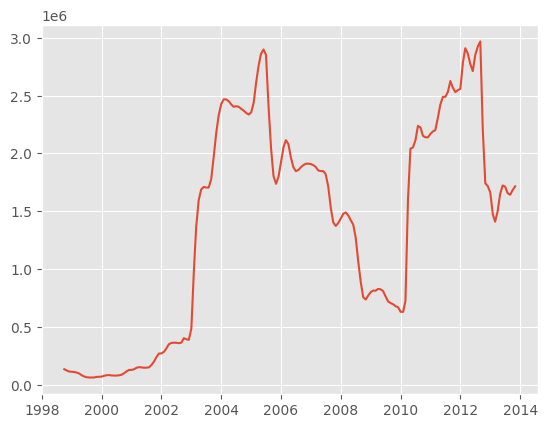

In [42]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals['value'].rolling(30).var());

If we look at the rolling standard deviation of our errors, we can see that the performance of our model varies at different points in time.

That is a result of the trends in our data.

# Differencing Data for Sationarity

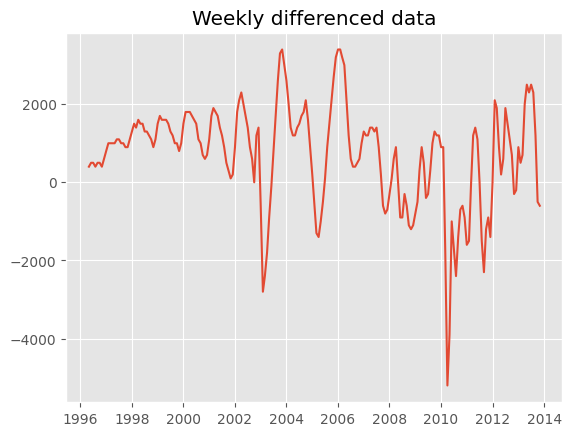

In [43]:
fig, ax = plt.subplots()
ax.plot(train.diff())
ax.set_title('Weekly differenced data');

In [44]:
p_val_diff = adfuller(train.diff()[1:])[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val_diff},")
if p_val_diff < 0.05:
    print(" so we can safely assume that the differenced data is stationary.")
else:
    print(" so we cannot reject the null hypothesis that the differenced data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 0.17914211184346313,
 so we cannot reject the null hypothesis that the differenced data is not stationary.


## Log Transformation, Square Root Transformation

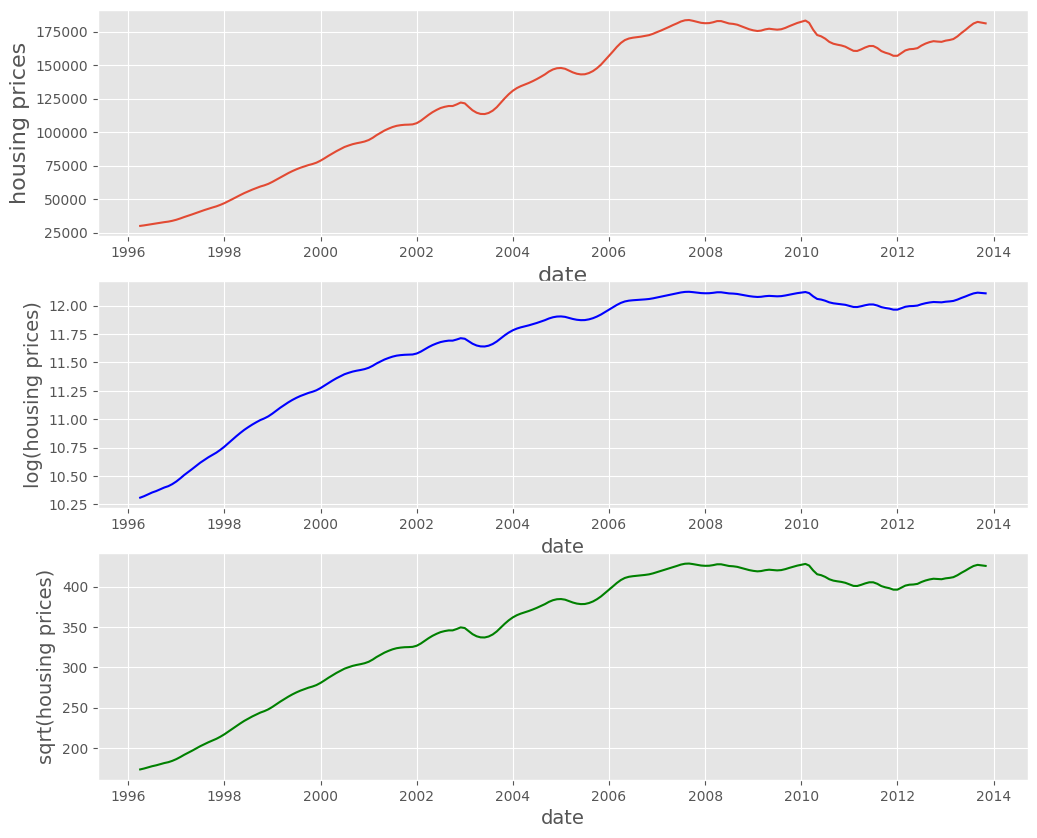

In [45]:
fig = plt.figure(figsize=(12,10))

# No transformation
plt.subplot(3, 1, 1)
plt.plot(train)
plt.xlabel("date", fontsize=16)
plt.ylabel("housing prices", fontsize=16)

# Log transformation (linear and heteroscedastic)
plt.subplot(3, 1, 2)
plt.plot(pd.Series(np.log(train['value']), index=train.index), color="blue")
plt.xlabel("date", fontsize=14)
plt.ylabel("log(housing prices)", fontsize=14)

# Square root transformation 
plt.subplot(3, 1, 3)
plt.plot(pd.Series(np.sqrt(train['value']), index=train.index), color="green")
plt.xlabel("date", fontsize=14)
plt.ylabel("sqrt(housing prices)", fontsize=14)


plt.show()

## Dicky Fuller Test for Log

In [46]:
p_val_log = adfuller(pd.Series(np.log(train['value']), index=train.index))[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val_log},")
if p_val_log < 0.05:
    print(" so we can safely assume that the differenced data is stationary.")
else:
    print(" so we cannot reject the null hypothesis that the differenced data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 1.0383671302190787e-05,
 so we can safely assume that the differenced data is stationary.


## Dicky Fuller Test for Square

In [47]:
p_val_sqrt = adfuller(pd.Series(np.sqrt(train['value']), index=train.index))[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val_sqrt},")
if p_val_sqrt < 0.05:
    print(" so we can safely assume that the differenced data is stationary.")
else:
    print(" so we cannot reject the null hypothesis that the differenced data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 0.0031352608063417915,
 so we can safely assume that the differenced data is stationary.


## Using the Rolling Mean to Subtract from Time Series

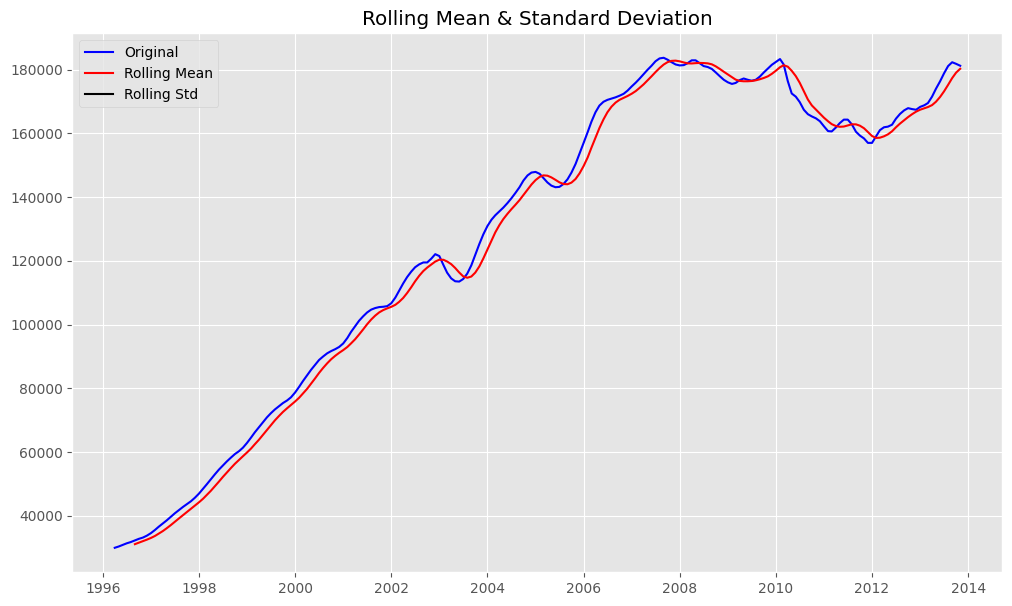

In [48]:
rolmean = train.rolling(window = 6, center = False).mean()
rolstd = train.rolling(window = 1, center = False).std()

fig = plt.figure(figsize=(12,7))
orig = plt.plot(train, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

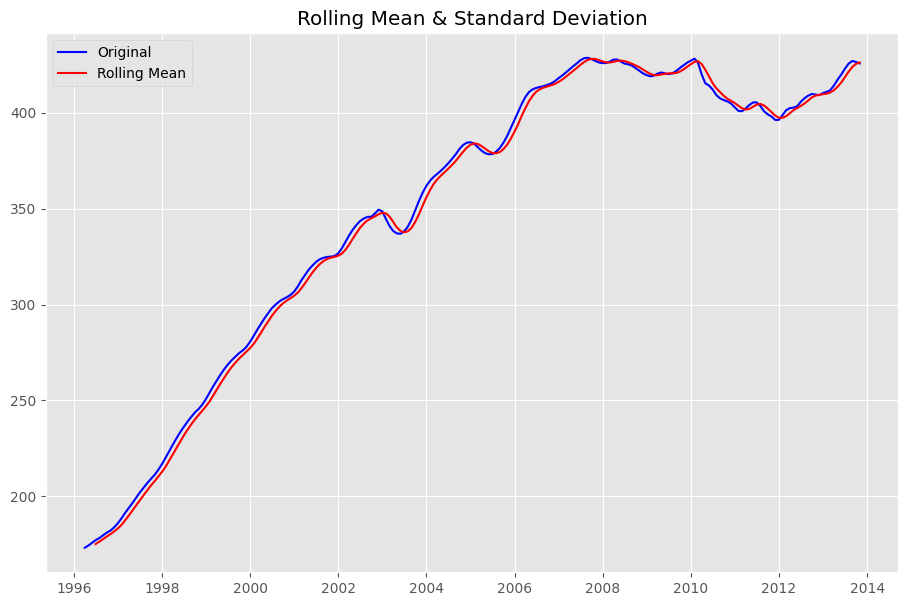

In [49]:
# Start with the square root transform
data_transform = pd.Series(np.sqrt(train['value']), index=train.index)

rolmean = data_transform.rolling(window = 4).mean()
fig = plt.figure(figsize=(11,7))
orig = plt.plot(data_transform, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [50]:
data_minus_rolmean = data_transform - rolmean

In [51]:
# Drop the NaN values from timeseries calculated above 
# (the first few values didn't have a rolling mean)
data_minus_rolmean.dropna(inplace=True)

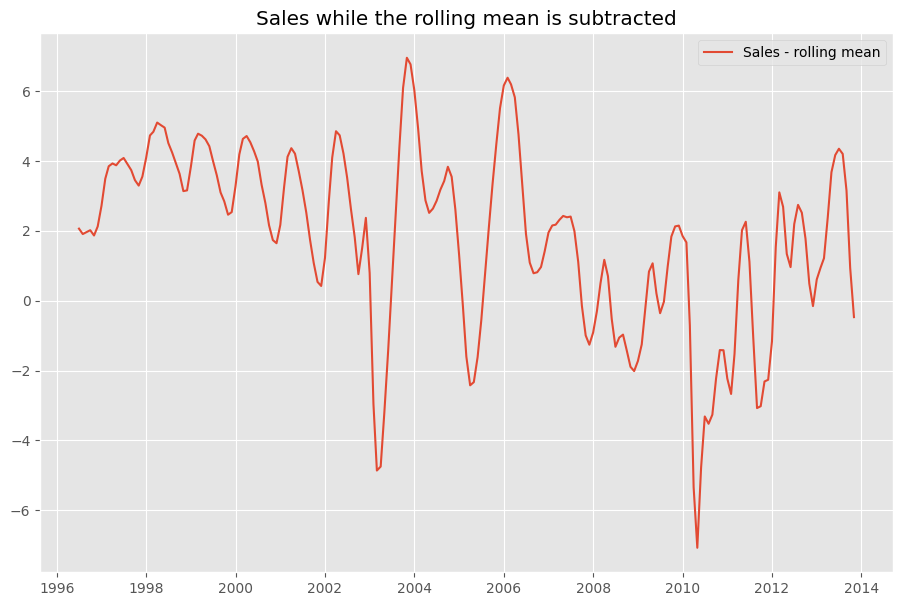

In [52]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_rolmean, label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Sales while the rolling mean is subtracted')
plt.show(block=False)

In [53]:
p_val_roll = adfuller(train.diff()[1:])[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val_roll},")
if p_val_roll < 0.05:
    print(" so we can safely assume that the differenced data is stationary.")
else:
    print(" so we cannot reject the null hypothesis that the differenced data is \
not stationary.")


The p-value associated with the Dickey-Fuller statistical test is 0.17914211184346313,
 so we cannot reject the null hypothesis that the differenced data is not stationary.


In [54]:
print(f"The p-value associated with the Dickey-Fuller statistical test using Differencing is {p_val_diff}")
print(f"The p-value associated with the Dickey-Fuller statistical test using Log is {p_val_log}")
print(f"The p-value associated with the Dickey-Fuller statistical test using Square Root is {p_val_sqrt}")
print(f"The p-value associated with the Dickey-Fuller statistical test using Subtracting the Rolling Mean is {p_val_roll}")
p_value_list = [p_val_diff, p_val_log, p_val_sqrt, p_val_roll]
print(f"The p-value that is the lowest is {min(p_value_list)}")
    
    

The p-value associated with the Dickey-Fuller statistical test using Differencing is 0.17914211184346313
The p-value associated with the Dickey-Fuller statistical test using Log is 1.0383671302190787e-05
The p-value associated with the Dickey-Fuller statistical test using Square Root is 0.0031352608063417915
The p-value associated with the Dickey-Fuller statistical test using Subtracting the Rolling Mean is 0.17914211184346313
The p-value that is the lowest is 1.0383671302190787e-05


# Fitting an AUTO-ARIMA Model on our Training Series


For time series modeling a stationary dataset is usually required to create an accurate prediction model. However, by utilizing an AUTO-ARIMA model, the model itself will generate the optimal values to eliminate stationarity and create predictions. As a result, in order to streamline the process of modeling a AUTO-ARIMA model will be built using the data from the zipcode. 

In [55]:
# Creating and Fitting an AUTO ARIMA model to the train dataset
import pmdarima as pm

auto_model = pm.auto_arima(train, start_p=0, start_q=0,
                     test='adf',
                     max_p=5, max_q=5,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)



print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5619.246, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5469.614, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3467.587, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=nan sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3306.898, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5439.494, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3266.128, Time=0.17 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=3292.353, Time=0.18 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3271.109, Time=0.19 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 1

In [56]:
#Identifying the order values for the model
auto_model.order

(2, 0, 2)

In [57]:
#Identifying the Seasonal Order values for the model
auto_model.seasonal_order

(0, 0, 0, 0)

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.88306D+00    |proj g|=  1.38146D+00

At iterate    5    f=  7.61097D+00    |proj g|=  1.66001D+00

At iterate   10    f=  7.56995D+00    |proj g|=  4.57613D-01

At iterate   15    f=  7.55669D+00    |proj g|=  2.01208D+00

At iterate   20    f=  7.55617D+00    |proj g|=  8.22590D-01

At iterate   25    f=  7.54812D+00    |proj g|=  3.28305D+00

At iterate   30    f=  7.54247D+00    |proj g|=  1.81740D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

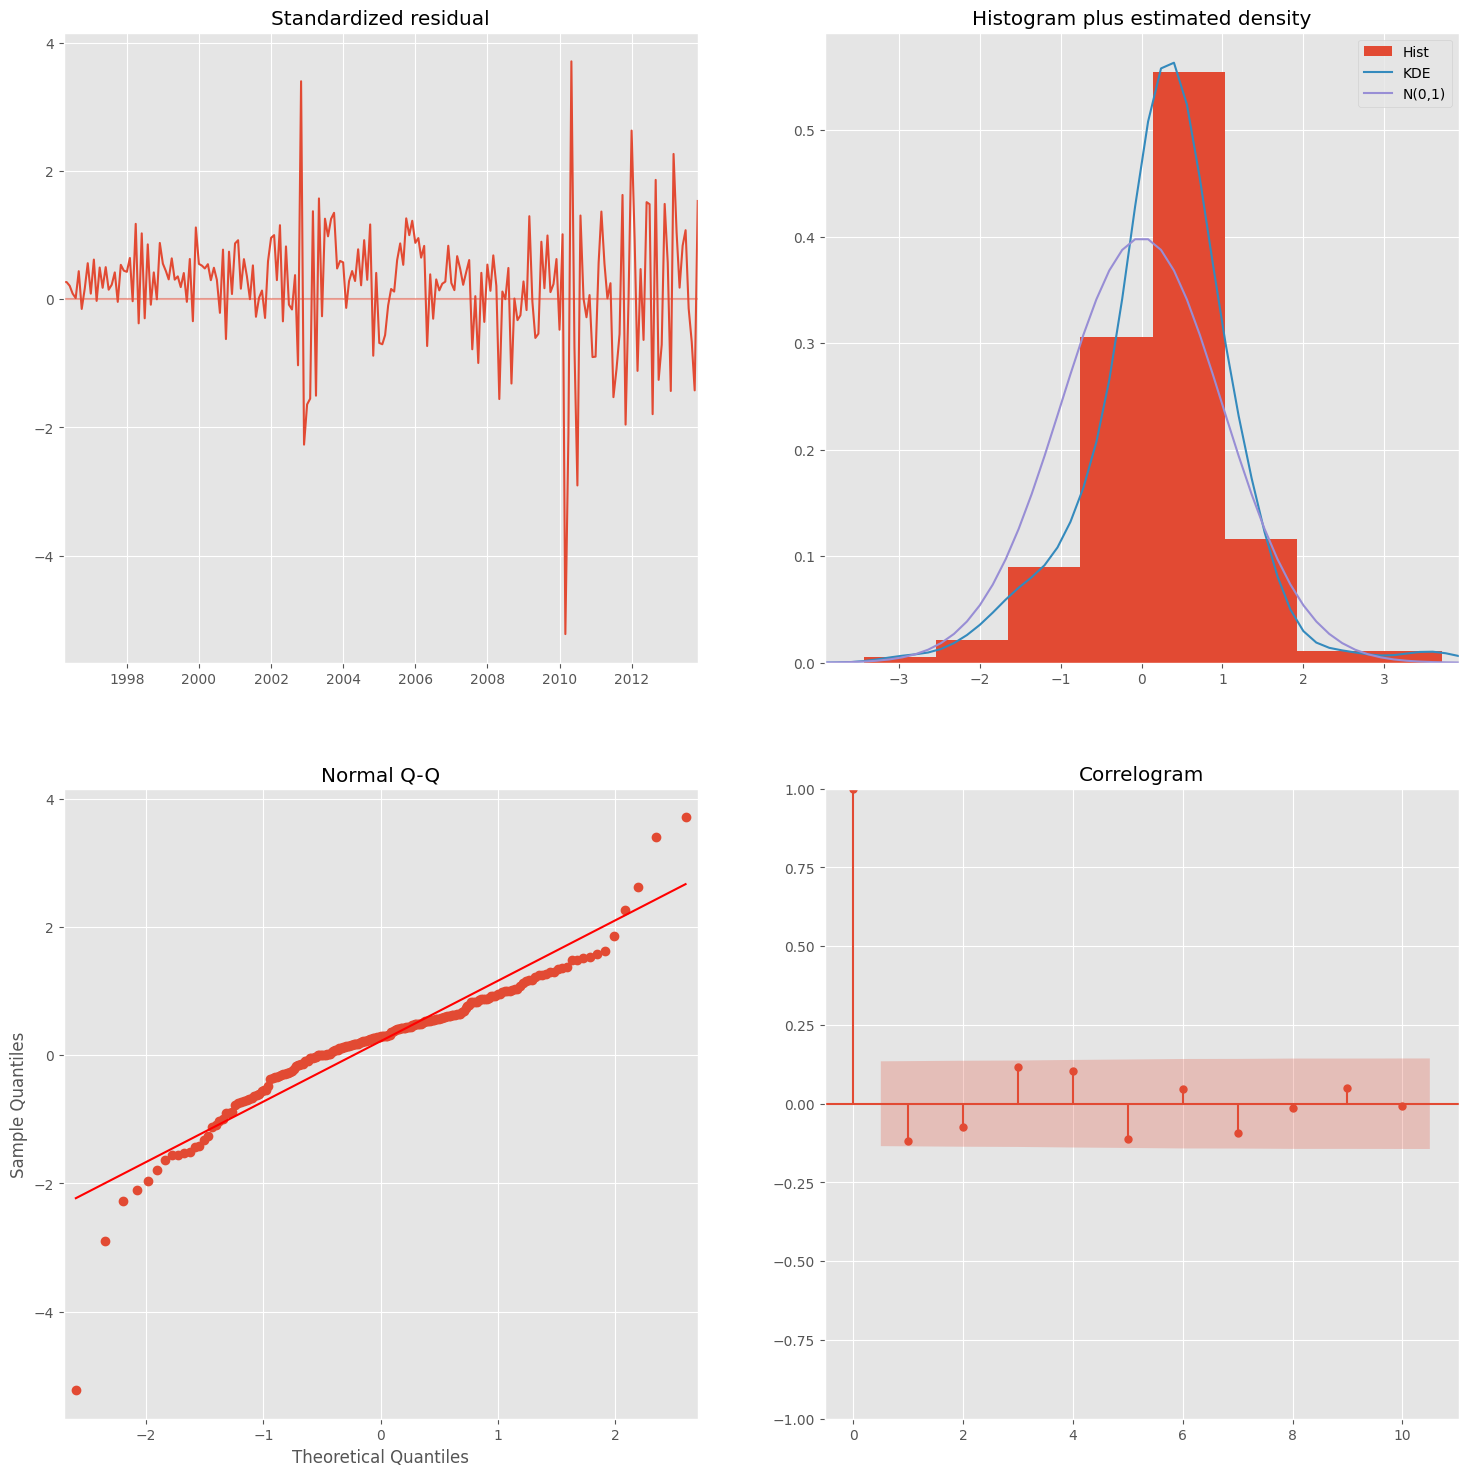

In [58]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(train, 
                                        order=(2,0,2), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output_arima = ARIMA_MODEL.fit()

print(output_arima.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

It is important to confirm that the residuals are not correlated and that they are normally distributed. Otherwise, additional changes will need to be made to the model. 

Checking each of the diagnostic plots:

- In the plot on the top right, the KDE line somewhat closely follows along the N(0,1) line which is the standard notation for a normal distribution having a mean of 0 and a standard deviation of 1. As a result, this can be interpreted to mean that the residuals are normally distributed. 

- The qq-plot shwon on the bottom left displays that the residuals follow the linear trend line. As a result, it can also be interpreted to mean that the residuals are normally distributed. 

- From the Correlogram plot on the bottom left, it can be seen that the time series residuals displace low correlation with their lagged versions. This becomes clearer as the time series continues further along. This seems to indicate that there isn't any obvious seasonality in our series. 

Based on these observations, it can be confidently concluded that the model does not have correlations and that it satisfactorily fits the data to forecast future prices. 

In [59]:
output_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  212
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -1599.003
Date:                Wed, 24 May 2023   AIC                           3208.005
Time:                        18:29:07   BIC                           3224.717
Sample:                    04-01-1996   HQIC                          3214.762
                         - 11-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6384      0.061     26.952      0.000       1.519       1.758
ar.L2         -0.6370      0.061    -10.456      0.000      -0.756      -0.518
ma.L1          1.0645      0.066     16.227      0.000       0.936       1.193
ma.L2          0.3296      0.075      4.395      0.000       0.183       0.477
sigma2      2.557e+05   1.97e-07    1.3e+12      0.000    2.56e+05    2.56e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):               292.20
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               6.75   Skew:                            -1.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.91e+27. Standard errors may be unstable.
"""

In [87]:
print(output_arima.aic)

3208.0054081256285


# Evaluating the ARIMA Model Performance

In order to test the accuracy of the model, the predictions for the period between May 2013 and April 2018 will be retrieved. The predictions will be plotted on the same chart to see how far and/or close they are.

In [94]:
pred_arima = output_arima.get_prediction(start=pd.to_datetime('2013-12'), end=pd.to_datetime('2018-04'), dynamic=False)
pred_conf_arima = pred_arima.conf_int()

In [95]:
output_arima

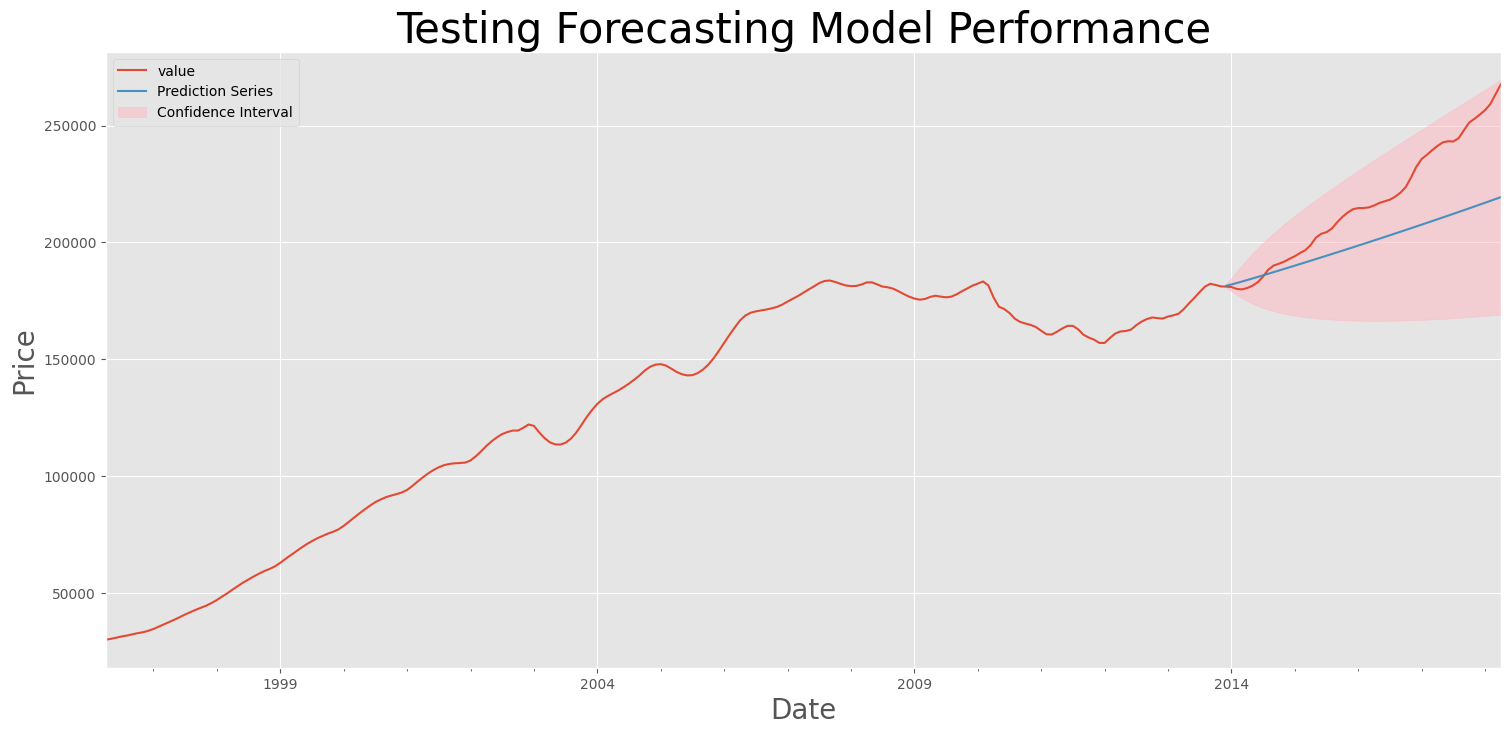

In [62]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 18, 8

# Plot observed values
ax = series80449.plot(label='observed')

# Plot predicted values
pred_arima.predicted_mean.plot(ax=ax, label='Prediction Series', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf_arima.index,
                pred_conf_arima.iloc[:, 0],
                pred_conf_arima.iloc[:, 1], color='lightpink', alpha=0.5,label = 'Confidence Interval')

# Set axes labels
ax.set_xlabel('Date',fontsize=20)
ax.set_ylabel('Price',fontsize=20)
ax.set_title('Testing Forecasting Model Performance',fontsize=30)
plt.legend()

plt.show()

In [91]:
arima_test_rmse = np.sqrt(mean_squared_error(test, pred_arima))

TypeError: Expected sequence or array-like, got <class 'statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper'>

In [92]:
print(test)

               value
time                
2013-12-01  181100.0
2014-01-01  180900.0
2014-02-01  180100.0
2014-03-01  179900.0
2014-04-01  180500.0
2014-05-01  181500.0
2014-06-01  183000.0
2014-07-01  185400.0
2014-08-01  188400.0
2014-09-01  190100.0
2014-10-01  190900.0
2014-11-01  191800.0
2014-12-01  193000.0
2015-01-01  194100.0
2015-02-01  195500.0
2015-03-01  196700.0
2015-04-01  198900.0
2015-05-01  202100.0
2015-06-01  203700.0
2015-07-01  204400.0
2015-08-01  205900.0
2015-09-01  208600.0
2015-10-01  210900.0
2015-11-01  212800.0
2015-12-01  214200.0
2016-01-01  214700.0
2016-02-01  214700.0
2016-03-01  215000.0
2016-04-01  215800.0
2016-05-01  216900.0
2016-06-01  217600.0
2016-07-01  218300.0
2016-08-01  219600.0
2016-09-01  221300.0
2016-10-01  223700.0
2016-11-01  227800.0
2016-12-01  232400.0
2017-01-01  235700.0
2017-02-01  237500.0
2017-03-01  239500.0
2017-04-01  241300.0
2017-05-01  242800.0
2017-06-01  243300.0
2017-07-01  243200.0
2017-08-01  244600.0
2017-09-01  2

In [93]:
print(pred_arima)

In [88]:
print(f"The RMSE value associated with the AUTO ARIMA model is {arima_rmse}.")
if arima_rmse < base_rmse:
    print("Based on RMSE value the AUTO ARIMA model has outperformed the Baseline Model")
else:
    print(f"Based on RMSE value the AUTO ARIMA model has been outperformed by the Baseline Model with a RMSE of {base_rmse}")

The RMSE value associated with the AUTO ARIMA model is 2498.8751524461395.
Based on RMSE value the AUTO ARIMA model has been outperformed by the Baseline Model with a RMSE of 1473.5262538730283


# Fitting an Facebook Prophet Model on the Training Series¶

In [64]:
train

,value
time,
1996-04-01,30000.0
1996-05-01,30400.0
1996-06-01,30900.0
1996-07-01,31400.0
1996-08-01,31800.0
...,...
2013-07-01,178800.0
2013-08-01,181100.0
2013-09-01,182300.0


In [65]:
fb_train = pd.Series(np.log(train['value']), index=train.index)
fb_train = fb_train.reset_index()

In [66]:
fb_train

,time,value
0,1996-04-01,10.308953
1,1996-05-01,10.322198
2,1996-06-01,10.338511
3,1996-07-01,10.354563
4,1996-08-01,10.367222
...,...,...
207,2013-07-01,12.094023
208,2013-08-01,12.106805
209,2013-09-01,12.113409
210,2013-10-01,12.110662


In [67]:
fb_train = fb_train.rename(columns={'value': 'y', 'time': 'ds'})
fb_train.head(5)

,ds,y
0,1996-04-01,10.308953
1,1996-05-01,10.322198
2,1996-06-01,10.338511
3,1996-07-01,10.354563
4,1996-08-01,10.367222


In [68]:
FB_Model = Prophet()

FB_Model.fit(fb_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [69]:
fb_future_dates = FB_Model.make_future_dataframe(periods=53, freq='MS')
fb_future_dates.tail()

,ds
260,2017-12-01
261,2018-01-01
262,2018-02-01
263,2018-03-01
264,2018-04-01


In [70]:
fb_forecast = FB_Model.predict(fb_future_dates)
fb_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1996-04-01,10.292694,10.265570,10.324427,10.292694,10.292694,0.003198,0.003198,0.003198,0.003198,0.003198,0.003198,0.0,0.0,0.0,10.295893
1,1996-05-01,10.310103,10.284023,10.343024,10.310103,10.310103,0.004188,0.004188,0.004188,0.004188,0.004188,0.004188,0.0,0.0,0.0,10.314292
2,1996-06-01,10.328092,10.304932,10.361686,10.328092,10.328092,0.003915,0.003915,0.003915,0.003915,0.003915,0.003915,0.0,0.0,0.0,10.332007
3,1996-07-01,10.345501,10.317642,10.377948,10.345501,10.345501,0.004101,0.004101,0.004101,0.004101,0.004101,0.004101,0.0,0.0,0.0,10.349602
4,1996-08-01,10.363490,10.339777,10.396667,10.363490,10.363490,0.003933,0.003933,0.003933,0.003933,0.003933,0.003933,0.0,0.0,0.0,10.367423


In [71]:
fb_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,1996-04-01,10.295893,10.265570,10.324427
1,1996-05-01,10.314292,10.284023,10.343024
2,1996-06-01,10.332007,10.304932,10.361686
3,1996-07-01,10.349602,10.317642,10.377948
4,1996-08-01,10.367423,10.339777,10.396667


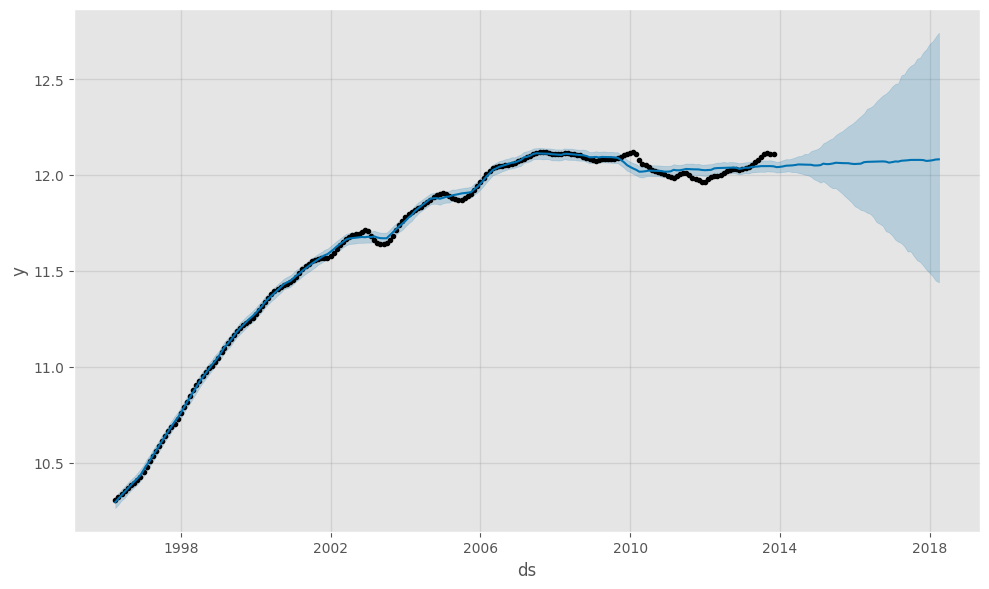

In [72]:
FB_Model.plot(fb_forecast, uncertainty=True)
plt.show();

In [73]:
fb_test = pd.Series(np.log(test['value']), index=test.index)
fb_test = fb_test.reset_index()

In [74]:
fb_test = fb_test.rename(columns={'value': 'y', 'time': 'ds'})
fb_test.head(5)

,ds,y
0,2013-12-01,12.106805
1,2014-01-01,12.105700
2,2014-02-01,12.101268
3,2014-03-01,12.100156
4,2014-04-01,12.103486


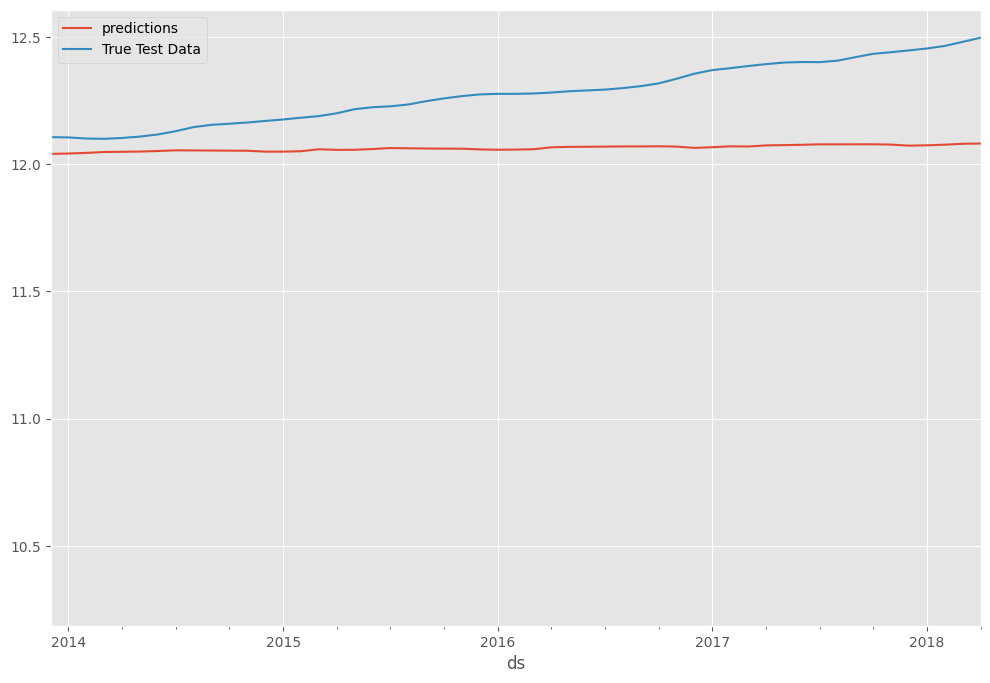

In [75]:
ax=fb_forecast.plot(x='ds',y='yhat',legend=True,label='predictions',figsize=(12,8))
fb_test.plot(x='ds',y='y',legend=True,label='True Test Data',ax=ax,xlim=('2013-12-01','2018-04-01'));

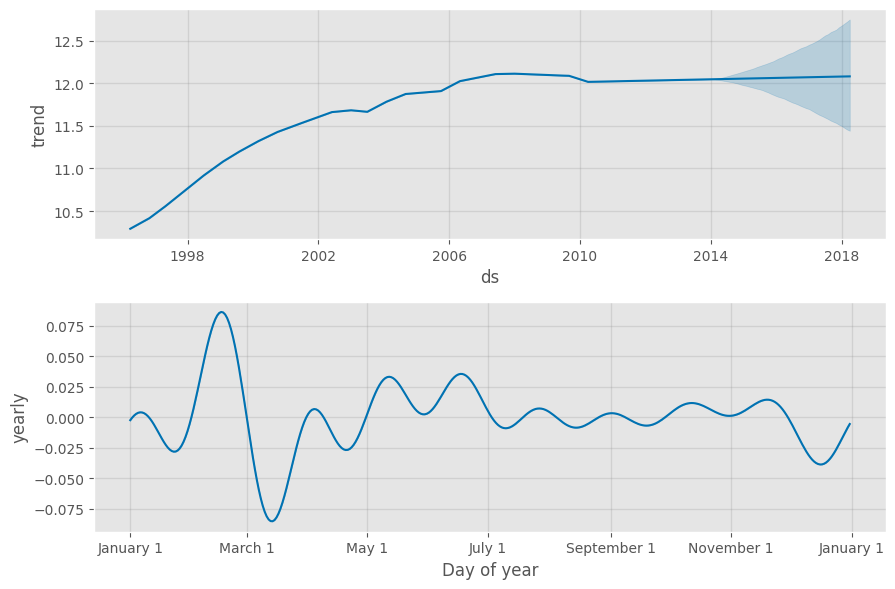

In [76]:
fig=FB_Model.plot_components(fb_forecast)

## Evaluating the Facebook Prophet Model

In [ ]:
arima_rmse = np.sqrt(mean_squared_error(train, y_hat_arima))

In [81]:
fb_cv = cross_validation(FB_Model, initial='6330 days', horizon = '5 days')

INFO:prophet:Making 3 forecasts with cutoffs between 2013-08-27 00:00:00 and 2013-10-27 00:00:00
  0%|                                                     | 0/3 [00:00<?, ?it/s]INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
 33%|███████████████                              | 1/3 [00:00<00:00,  4.51it/s]INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
 67%|██████████████████████████████               | 2/3 [00:00<00:00,  5.40it/s]INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  5.55it/s]


In [82]:
fb_pm = performance_metrics(fb_cv)
fb_pm

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,5 days,0.007715,0.087837,0.087383,0.007215,0.007042,0.007242,0.0


# Forecasting the Future

In [79]:
# Plug the parameter values from our Auto ARIMA model into a new SARIMAX model that fits the entire series.
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(recent_series, 
                                        order=(1,0,2), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
full_output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

NameError: name 'recent_series' is not defined

In [ ]:
## Getting a forecast for the next 36 months after the last recorded date on our dataset.
forecast = full_output.get_forecast(36)
future_prediction = forecast.conf_int()
future_prediction['value'] = forecast.predicted_mean
future_prediction.columns = ['lower','upper','prediction'] 
future_prediction

In [ ]:
#Plotting our Forecast

fig, ax = plt.subplots()
recent_series.plot(ax=ax,label='Real Values')


future_prediction['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= future_prediction.index, y1= future_prediction['lower'], 
                y2= future_prediction['upper'],color='lightpink',
                label='Confidence Interval')
ax.legend() 
plt.ylabel("Average Price")
plt.title('Average Home Price - 33602 - With Forcasted Value & Confidence Intervals')
plt.show()


# Forecasting on All Top 25 Zip Codes in Clients Budget


In [ ]:
zip_predictions = {}
top_25_for_modeling = top_25_modeling_df.drop(columns='roi_since11')

for zipcode in top_25_for_modeling['RegionName']:

    series = melt_data(top_25_for_modeling[top_25_for_modeling['RegionName']==zipcode])
   
    #Only taking data from 2011 onwards to more accurately reflect current market conditions
    recent_series = series['2011':]
    
    #Splitting the last 36 months of our series as a test dataset.
    train_series = recent_series[:'2016-04']
    test_series = recent_series['2016-05':]
    
    #Auto ARIMA model
    auto_model = pm.auto_arima(train_series, start_p=0, start_q=0,
                     test='adf',
                     max_p=5, max_q=5,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
   
    # Plug the optimal parameter values for our Training data into a SARIMAX model that fits our entire series.
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(recent_series, 
                                            order= auto_model.order, 
                                            seasonal_order= auto_model.seasonal_order, 
                                            enforce_stationarity=False, 
                                            enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()

    ## Getting a forecast for the next 36 months after the last absrecorded date on our dataset.
    forecast = output.get_forecast(36)
    prediction = forecast.conf_int()
    prediction['value'] = forecast.predicted_mean
    prediction.columns = ['lower','upper','prediction'] 
    
    #Adding the Zipcode's ROI to the zip_predictions dictionary
    zip_predictions[zipcode] = ((prediction['prediction'][-1])
                                - (series['value'][-1]))/ (series['value'][-1])

In [ ]:
# Sorting our 3 year ROI forecast for zipcodes into descending order
sort_orders = sorted(zip_predictions.items(), key=lambda x: x[1], reverse=True)

sorted_forecast_3yr = {}
for i in sort_orders:
	sorted_forecast_3yr[i[0]] = i[1]

#Selecting only the Top 5 Zips
top_5_zipcodes = list(sorted_forecast_3yr.items())[:5]

fig, ax = plt.subplots(figsize=(18,12))

x_labels = [top_5_zipcodes[0][0],top_5_zipcodes[1][0],top_5_zipcodes[2][0],
            top_5_zipcodes[3][0],top_5_zipcodes[4][0]]
x = [1,2,3,4,5]
y = [top_5_zipcodes[0][1],top_5_zipcodes[1][1],top_5_zipcodes[2][1],
     top_5_zipcodes[3][1],top_5_zipcodes[4][1]]

ax.bar(x, y, color='mediumslateblue')
remaining_zipcodes = list(sorted_forecast_3yr.items())[5:]
median_ROI_other_zips = remaining_zipcodes[5][1]
ax.axhline(y=median_ROI_other_zips,label = 'Median ROI for remaining Zips')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_yticks([(a/100) for a in list(range(0,75,5))])
ax.set_yticklabels([str(a)+'%' for a in list(range(0,75,5))])
ax.set_title('Top 5 Recommendations', fontsize=20)
ax.set_ylabel('Average ROI', fontsize=20)
ax.set_xlabel('Zipcodes',fontsize=20)
ax.legend(prop={'size': 15});

# Conclusion

In [ ]:
print(f'The Highest Growing Zipcode: {list(sorted_forecast_3yr.items())[0][0]} is expected to grow by {round((list(sorted_forecast_3yr.items())[0][1])*100,2)}%')
print(f'The Second Highest Growing Zipcode: {list(sorted_forecast_3yr.items())[1][0]} is expected to grow by {round((list(sorted_forecast_3yr.items())[1][1])*100,2)}%')
print(f'The Third Highest Growing Zipcode: {list(sorted_forecast_3yr.items())[2][0]} is expected to grow by {round((list(sorted_forecast_3yr.items())[2][1])*100,2)}%')
print(f'The Fourth Highest Growing Zipcode: {list(sorted_forecast_3yr.items())[3][0]} is expected to grow by {round((list(sorted_forecast_3yr.items())[3][1])*100,2)}%')
print(f'The Fifth Highest Growing Zipcode: {list(sorted_forecast_3yr.items())[4][0]} is expected to grow by {round((list(sorted_forecast_3yr.items())[4][1])*100,2)}%')

In [ ]:
recommended_zips = pd.DataFrame([a for a in sorted_forecast_3yr.keys()][:5])
recommended_zips.columns = ['RegionName']
final_zips_map = pd.merge(recommended_zips, zip_long_lat, how="left", on=["RegionName"])
print(final_zips_map)

In [ ]:
geometry = [Point(xy) for xy in zip(final_zips_map['Longitude'], final_zips_map['Latitude'])] #create Points
geo_df = gpd.GeoDataFrame(final_zips_map, 
                          crs = crs, 
                          geometry = geometry) #define the geometry df

#plot the data
fig, ax = plt.subplots(figsize = (10,10))
us49.to_crs(epsg=4326).plot(ax=ax)
sns.scatterplot(x="Longitude", y="Latitude",data=final_zips_map, ax=ax)
ax.set_title('Distribution of Top 5 Most Profitable Zip Codes');